In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Leiden Uni/Audio Processing/release_in_the_wild.zip"

Streaming output truncated to the last 5000 lines.
  inflating: release_in_the_wild/22251.wav  
  inflating: release_in_the_wild/22472.wav  
  inflating: release_in_the_wild/21437.wav  
  inflating: release_in_the_wild/1451.wav  
  inflating: release_in_the_wild/9082.wav  
  inflating: release_in_the_wild/20810.wav  
  inflating: release_in_the_wild/4210.wav  
  inflating: release_in_the_wild/12376.wav  
  inflating: release_in_the_wild/2772.wav  
  inflating: release_in_the_wild/22039.wav  
  inflating: release_in_the_wild/9847.wav  
  inflating: release_in_the_wild/15569.wav  
  inflating: release_in_the_wild/8969.wav  
  inflating: release_in_the_wild/21759.wav  
  inflating: release_in_the_wild/19010.wav  
  inflating: release_in_the_wild/19318.wav  
  inflating: release_in_the_wild/5514.wav  
  inflating: release_in_the_wild/20657.wav  
  inflating: release_in_the_wild/12380.wav  
  inflating: release_in_the_wild/27769.wav  
  inflating: release_in_the_wild/7749.wav  
  inflating:

In [4]:
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


audio_folder = "/content/release_in_the_wild"  # Update folder name if different

# Load metadata
meta_path =  "/content/release_in_the_wild/meta.csv"
meta = pd.read_csv(meta_path)

# Filter out only bona-fide examples if needed
meta = meta[meta['label'] == 'bona-fide']

# Function to extract features from audio
def extract_features(audio_file, sr=16000, n_mfcc=13):
    try:
        # Load audio file
        y, sr = librosa.load(audio_file, sr=sr)
        # Compute MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Return the mean of the MFCCs over time
        return np.mean(mfccs, axis=1)
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

# Extract features and prepare the dataset
features, labels = [], []
for _, row in meta.iterrows():
    file_path = os.path.join(audio_folder, row['file'])
    speaker = row['speaker']

    # Extract features
    feature = extract_features(file_path)
    if feature is not None:
        features.append(feature)
        labels.append(speaker)

# Convert features and labels to arrays
X = np.array(features)
y = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.93
Classification Report:
                          precision    recall  f1-score   support

                    2Pac       1.00      0.92      0.96        12
             Adam Driver       1.00      0.94      0.97        16
              Alan Watts       1.00      0.29      0.45        17
           Alec Guinness       0.90      0.97      0.94       381
Alexandria Ocasio-Cortez       0.94      0.86      0.90        58
   Arnold Schwarzenegger       0.91      0.63      0.75        49
                Ayn Rand       0.97      0.97      0.97       278
            Barack Obama       0.87      0.98      0.92       660
          Bernie Sanders       0.96      0.94      0.95       325
               Bill Burr       0.91      0.72      0.81        29
            Bill Clinton       0.97      0.93      0.95       226
           Billie Eilish       0.00      0.00      0.00         2
                Bob Ross       1.00      0.83      0.91        12
           Boris Johnson       0.92  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualize results

In [7]:
def test_single_audio(file_path, model):
    feature = extract_features(file_path)  # Reuse the feature extraction function
    if feature is not None:
        feature = feature.reshape(1, -1)  # Reshape to match the model's input
        prediction = model.predict(feature)
        return prediction[0]
    else:
        print("Failed to extract features from the audio file.")
        return None

# Example Usage
file_path = "/content/release_in_the_wild/7.wav"
predicted_speaker = test_single_audio(file_path, clf)  # clf is the trained model
print(f"The predicted speaker is: {predicted_speaker}")

The predicted speaker is: Donald Trump


In [13]:
from IPython.display import Audio, display

display(Audio(file_path, autoplay=True))

In [6]:
# Combine the true labels and predicted labels into a DataFrame for easy analysis
results_df = pd.DataFrame({'True_Label': y_test, 'Predicted_Label': y_pred})

# Identify correctly classified examples
correctly_classified = results_df[results_df['True_Label'] == results_df['Predicted_Label']]
print("Correctly Classified Examples:")
print(correctly_classified)

# Identify misclassified examples
misclassified = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
print("\nMisclassified Examples:")
print(misclassified)


Correctly Classified Examples:
                 True_Label        Predicted_Label
0             Alec Guinness          Alec Guinness
1            Bernie Sanders         Bernie Sanders
2            Nelson Mandela         Nelson Mandela
3         Dwight Eisenhower      Dwight Eisenhower
4             Alec Guinness          Alec Guinness
...                     ...                    ...
3987          Alec Guinness          Alec Guinness
3988           Barack Obama           Barack Obama
3989          Alec Guinness          Alec Guinness
3991         Bernie Sanders         Bernie Sanders
3992  Arnold Schwarzenegger  Arnold Schwarzenegger

[3702 rows x 2 columns]

Misclassified Examples:
                True_Label  Predicted_Label
32    Christopher Hitchens  Mark Zuckerberg
59          Bernie Sanders     Donald Trump
61           George Carlin     Barack Obama
81           Jeff Goldblum     Donald Trump
118               Ayn Rand    Alec Guinness
...                    ...              ...

In [10]:
correct_count = len(correctly_classified)
incorrect_count = len(misclassified)

print(f"Correctly Classified: {correct_count}")
print(f"Incorrectly Classified: {incorrect_count}")


Correctly Classified: 3702
Incorrectly Classified: 291


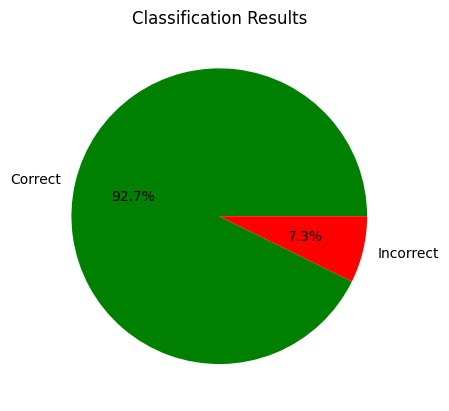

In [11]:
import matplotlib.pyplot as plt

counts = [correct_count, incorrect_count]
labels = ['Correct', 'Incorrect']
colors = ['green', 'red']

plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title("Classification Results")
plt.show()
